### CNN+biLSTM+Attention - 1000 random samples 
1. text only (similar params and architecture with CNN+biLSTM)
2. text and personality traits (similar params and architecture with CNN+biLSTM)
3. 

1. text only

In [48]:
#Import Libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
import re
import html
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [49]:
data = pd.read_csv('Suicide_Detection_final1.csv')
data

,Unnamed: 0,text,class,Openness to Experience,Conscientiousness,Extraversion,Agreeableness,Neuroticism
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide,51%,68%,27%,35%,67%
1,3,Am I weird I don't get affected by compliments...,non-suicide,98%,0%,1%,17%,100%
2,4,Finally 2020 is almost over... So I can never ...,non-suicide,89%,7%,1%,11%,56%
3,16,"Everyone wants to be ""edgy"" and it's making me...",non-suicide,97%,12%,22%,26%,93%
4,19,I took the rest of my sleeping pills and my pa...,suicide,98%,69%,0%,63%,90%
...,...,...,...,...,...,...,...,...
995,2521,I'm a 17 year old senior and I sometimes feel ...,suicide,75%,37%,26%,36%,85%
996,2530,I just want to go to sleep and not wake upI ha...,suicide,76%,21%,0%,17%,97%
997,2534,Help. I'm so lost.I feel so helpless despite t...,suicide,88%,25%,18%,15%,99%
998,2535,Anybody else get really scared when you get cl...,suicide,98%,41%,49%,54%,98%


In [50]:
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    my_stopwords = set(stopwords.words('english'))
    add_stopwords = ['#ff', 'ff', 'rt']
    my_stopwords.update(add_stopwords)
    tokenizer = TweetTokenizer(reduce_len=True)
    lemmatizer = WordNetLemmatizer()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove punctuations and numbers
    text = re.sub(r'[^a-zA-Z]', ' ', text)

    # Lowercasing
    text = text.lower()

    # Tokenization
    tokens = tokenizer.tokenize(text)

    # Remove stop word
    tokens = [word for word in tokens if word not in my_stopwords]

    # Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    text = ' '.join(tokens)

    return text

data['preprocessed_text'] = data.text.apply(preprocess_text)
data[['text','preprocessed_text']].head(10)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,text,preprocessed_text
0,Ex Wife Threatening SuicideRecently I left my ...,ex wife threatening suiciderecently left wife ...
1,Am I weird I don't get affected by compliments...,weird get affected compliment coming someone k...
2,Finally 2020 is almost over... So I can never ...,finally almost never hear bad year ever swear ...
3,"Everyone wants to be ""edgy"" and it's making me...",everyone want edgy making self conscious feel ...
4,I took the rest of my sleeping pills and my pa...,took rest sleeping pill painkillersi wait end ...
5,Can you imagine getting old? Me neither.Wrinkl...,imagine getting old neither wrinkle weight gai...
6,Do you think getting hit by a train would be p...,think getting hit train would painful gun hard...
7,"death, continuedI posted here before and saw s...",death continuedi posted saw something interest...
8,Fuck the verizon smart family app I can’t even...,fuck verizon smart family app even watch porn ...
9,I’m scared. Everything just seems to be gett...,scared everything seems getting worse worse yo...


In [51]:
# Convert class labels into numbers
y = data['class'].map({'suicide': 1, 'non-suicide': 0})

# Train set and test set split
X_train, X_test, y_train, y_test = train_test_split(data['preprocessed_text'], y, test_size=0.2, random_state=42)

In [52]:
import random

seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [53]:
from gensim.models import KeyedVectors

# Creat word index
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text into sequence
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Determine the maximum sequence length
max_length = max([len(seq) for seq in X_train_seq] + [len(seq) for seq in X_test_seq])

# Fill sequence
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length)

# Load GoogleNews pre-trained word vectors
word2vec_path = 'GoogleNews-vectors-negative300.bin'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

# Get the size of the vocabulary
num_words = len(tokenizer.word_index) + 1

# Create the word embedding matrix
embedding_matrix = np.zeros((num_words, 300))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    try:
        embedding_vector = word2vec[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        pass

In [56]:
# WITHOUT Attention (for comparison)
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Concatenate, Bidirectional, LSTM, Dense, Dropout
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

y_train = np.array(y_train)
y_test = np.array(y_test)

# Convert the labels to one-hot encoding
num_classes = 2
y_train_onehot = to_categorical(y_train, num_classes)
y_test_onehot = to_categorical(y_test, num_classes)

# Construct the model
embedding_dim = 300
filters = 100
kernel_size = 5
lstm_units = 100
dropout_rate = 0.3

model = Sequential()
model.add(Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False, name="embedding_layer"))
model.add(Conv1D(filters, kernel_size, activation='relu', name="conv1d_layer"))
model.add(MaxPooling1D(name="max_pooling_layer"))
model.add(Bidirectional(LSTM(lstm_units, dropout=dropout_rate, recurrent_dropout=dropout_rate, return_sequences=True, name="bidirectional_lstm")))
model.add(LSTM(lstm_units, name="lstm_layer"))
model.add(Dense(64, activation='relu', name="dense_layer_1"))
model.add(Dropout(dropout_rate, name="dropout_layer"))
model.add(Dense(num_classes, activation='softmax', name="output_layer"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# Train the model
batch_size = 64
epochs = 5
model.save_weights("init_weights.h5") # Save the untrained model weights for fair comparison
model.fit(X_train_padded, y_train_onehot,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test_padded, y_test_onehot))

# Evaluate the model
# Make predictions on the test data
lstm_y_prob = model.predict(X_test_padded)
# Find the class index with the maximum probability
lstm_y_pred = np.argmax(lstm_y_prob, axis=1)
# Convert one-hot-encoded test labels to category indices
y_test = np.argmax(y_test_onehot, axis=1)

print('Word2Vec + CNN-BiLSTM Results:')
print(classification_report(y_test, lstm_y_pred, digits=4))

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer (Embedding)  (None, 117, 300)         1419600   
                                                                 
 conv1d_layer (Conv1D)       (None, 113, 100)          150100    
                                                                 
 max_pooling_layer (MaxPooli  (None, 56, 100)          0         
 ng1D)                                                           
                                                                 
 bidirectional_31 (Bidirecti  (None, 56, 200)          160800    
 onal)                                                           
                                                                 
 lstm_layer (LSTM)           (None, 100)               120400    
                                                                 
 dense_layer_1 (Dense)       (None, 64)              

In [57]:
from keras.models import Model, Sequential
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, Multiply, Flatten, BatchNormalization
from keras.layers import Layer
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.utils import to_categorical
from keras_self_attention import SeqSelfAttention

y_train = np.array(y_train)
y_test = np.array(y_test)

# Convert the labels to one-hot encoding
num_classes = 2
y_train_onehot = to_categorical(y_train, num_classes)
y_test_onehot = to_categorical(y_test, num_classes)

# Model Parameters (as reference)
embedding_dim = 300
filters = 100
kernel_size = 5
lstm_units = 100
dropout_rate = 0.3

# Define Model
model2 = Sequential()
model2.add(Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False, name="embedding_layer"))
model2.add(Conv1D(filters, kernel_size, activation='relu', name="conv1d_layer"))
model2.add(MaxPooling1D(name="max_pooling_layer"))
model2.add(Bidirectional(LSTM(lstm_units, dropout=dropout_rate, recurrent_dropout=dropout_rate, return_sequences=True, name="bidirectional_lstm")))
model2.add(LSTM(lstm_units, return_sequences=True, name="lstm_layer"))
model2.add(SeqSelfAttention(attention_activation='softmax'))
model2.add(Flatten())
model2.add(Dense(64, activation='relu', name="dense_layer_1"))
model2.add(Dropout(dropout_rate, name="dropout_layer"))
model2.add(Dense(num_classes, activation='softmax', name="output_layer"))

# Compile Model
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model2.summary())

# Train the model
batch_size = 64
epochs = 5

model2.load_weights("init_weights.h5", by_name=True, skip_mismatch=True)  # Load the saved weights before training
model2.fit(X_train_padded, y_train_onehot,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test_padded, y_test_onehot))

# Evaluate the model
lstm2_y_prob = model2.predict(X_test_padded)
lstm2_y_pred = np.argmax(lstm2_y_prob, axis=1)
y_test = np.argmax(y_test_onehot, axis=1)

print('Word2Vec + CNN-BiLSTM with Attention Results:')
print(classification_report(y_test, lstm2_y_pred, digits=4))


Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer (Embedding)  (None, 117, 300)         1419600   
                                                                 
 conv1d_layer (Conv1D)       (None, 113, 100)          150100    
                                                                 
 max_pooling_layer (MaxPooli  (None, 56, 100)          0         
 ng1D)                                                           
                                                                 
 bidirectional_32 (Bidirecti  (None, 56, 200)          160800    
 onal)                                                           
                                                                 
 lstm_layer (LSTM)           (None, 56, 100)           120400    
                                                                 
 seq_self_attention_12 (SeqS  (None, 56, 100)        

c:\Users\PC\Documents\Master_Project\Suicide-Ideation-Detection-in-Social-Media-Using-Personality-Traits-main\venv\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


13/13 [==============================] - 13s 615ms/step - loss: 0.5615 - accuracy: 0.6975 - val_loss: 0.4708 - val_accuracy: 0.7650
Epoch 2/5
13/13 [==============================] - 6s 496ms/step - loss: 0.4353 - accuracy: 0.8150 - val_loss: 0.3879 - val_accuracy: 0.8650
Epoch 3/5
13/13 [==============================] - 6s 467ms/step - loss: 0.3887 - accuracy: 0.8550 - val_loss: 0.2713 - val_accuracy: 0.9150
Epoch 4/5
13/13 [==============================] - 6s 458ms/step - loss: 0.2803 - accuracy: 0.9125 - val_loss: 0.2325 - val_accuracy: 0.9350
Epoch 5/5
7/7 [==============================] - 1s 40ms/step
Word2Vec + CNN-BiLSTM with Attention Results:
              precision    recall  f1-score   support

           0     0.8750    0.9785    0.9239        93
           1     0.9792    0.8785    0.9261       107

    accuracy                         0.9250       200
   macro avg     0.9271    0.9285    0.9250       200
weighted avg     0.9307    0.9250    0.9251       200



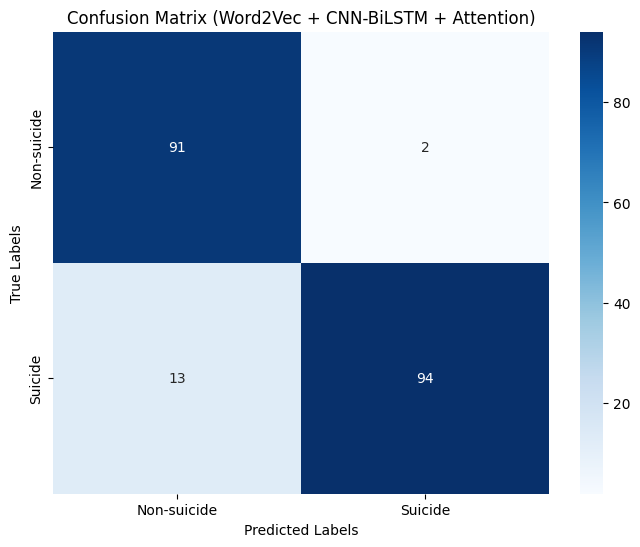

In [59]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, lstm2_y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-suicide', 'Suicide'], yticklabels=['Non-suicide', 'Suicide'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Word2Vec + CNN-BiLSTM + Attention)')
plt.show()

2. Text + personality traits


In [8]:
# Keep the desired columns
data = data[['text','Openness to Experience', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism', 'class']]

# Encode the 'class' column as a numeric type
data['class'] = data['class'].map({'non-suicide': 0, 'suicide': 1})

# Remove the percentage symbols and convert the data to floating numbers
data['Openness to Experience'] = data['Openness to Experience'].str.rstrip('%').astype(float)
data['Conscientiousness'] = data['Conscientiousness'].str.rstrip('%').astype(float)
data['Extraversion'] = data['Extraversion'].str.rstrip('%').astype(float)
data['Agreeableness'] = data['Agreeableness'].str.rstrip('%').astype(float)
data['Neuroticism'] = data['Neuroticism'].str.rstrip('%').astype(float)

# Check the data type of each column
print(data.dtypes)
data

text                       object
Openness to Experience    float64
Conscientiousness         float64
Extraversion              float64
Agreeableness             float64
Neuroticism               float64
class                       int64
dtype: object


C:\Users\PC\AppData\Local\Temp\ipykernel_26228\3006196770.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['class'] = data['class'].map({'non-suicide': 0, 'suicide': 1})
C:\Users\PC\AppData\Local\Temp\ipykernel_26228\3006196770.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Openness to Experience'] = data['Openness to Experience'].str.rstrip('%').astype(float)
C:\Users\PC\AppData\Local\Temp\ipykernel_26228\3006196770.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

,text,Openness to Experience,Conscientiousness,Extraversion,Agreeableness,Neuroticism,class
0,Ex Wife Threatening SuicideRecently I left my ...,51.0,68.0,27.0,35.0,67.0,1
1,Am I weird I don't get affected by compliments...,98.0,0.0,1.0,17.0,100.0,0
2,Finally 2020 is almost over... So I can never ...,89.0,7.0,1.0,11.0,56.0,0
3,"Everyone wants to be ""edgy"" and it's making me...",97.0,12.0,22.0,26.0,93.0,0
4,I took the rest of my sleeping pills and my pa...,98.0,69.0,0.0,63.0,90.0,1
...,...,...,...,...,...,...,...
995,I'm a 17 year old senior and I sometimes feel ...,75.0,37.0,26.0,36.0,85.0,1
996,I just want to go to sleep and not wake upI ha...,76.0,21.0,0.0,17.0,97.0,1
997,Help. I'm so lost.I feel so helpless despite t...,88.0,25.0,18.0,15.0,99.0,1
998,Anybody else get really scared when you get cl...,98.0,41.0,49.0,54.0,98.0,1


In [9]:
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    my_stopwords = set(stopwords.words('english'))
    add_stopwords = ['#ff', 'ff', 'rt']
    my_stopwords.update(add_stopwords)
    tokenizer = TweetTokenizer(reduce_len=True)
    lemmatizer = WordNetLemmatizer()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove punctuations and numbers
    text = re.sub(r'[^a-zA-Z]', ' ', text)

    # Lowercasing
    text = text.lower()

    # Tokenization
    tokens = tokenizer.tokenize(text)

    # Remove stop word
    tokens = [word for word in tokens if word not in my_stopwords]

    # Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    text = ' '.join(tokens)

    return text

data['preprocessed_text'] = data.text.apply(preprocess_text)
data[['text','preprocessed_text']].head(10)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,text,preprocessed_text
0,Ex Wife Threatening SuicideRecently I left my ...,ex wife threatening suiciderecently left wife ...
1,Am I weird I don't get affected by compliments...,weird get affected compliment coming someone k...
2,Finally 2020 is almost over... So I can never ...,finally almost never hear bad year ever swear ...
3,"Everyone wants to be ""edgy"" and it's making me...",everyone want edgy making self conscious feel ...
4,I took the rest of my sleeping pills and my pa...,took rest sleeping pill painkillersi wait end ...
5,Can you imagine getting old? Me neither.Wrinkl...,imagine getting old neither wrinkle weight gai...
6,Do you think getting hit by a train would be p...,think getting hit train would painful gun hard...
7,"death, continuedI posted here before and saw s...",death continuedi posted saw something interest...
8,Fuck the verizon smart family app I can’t even...,fuck verizon smart family app even watch porn ...
9,I’m scared. Everything just seems to be gett...,scared everything seems getting worse worse yo...


In [10]:
y = data['class']
X_train1, X_test1, y_train1, y_test1 = train_test_split(data['preprocessed_text'], y, test_size=0.2, random_state=42)


In [11]:
from gensim.models import KeyedVectors
from keras.utils import to_categorical

# Train set and test set split
y = data['class']
X_train, X_test, y_train, y_test = train_test_split(data[['preprocessed_text', 'Extraversion', 'Agreeableness', 'Neuroticism']], y, test_size=0.2, random_state=42)

# Tokenize and pad sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['preprocessed_text'])

X_train_seq = tokenizer.texts_to_sequences(X_train['preprocessed_text'])
X_test_seq = tokenizer.texts_to_sequences(X_test['preprocessed_text'])

num_classes = 2
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

max_length = max([len(seq) for seq in X_train_seq] + [len(seq) for seq in X_test_seq])

X_train_padded = pad_sequences(X_train_seq, maxlen=max_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length)

# Extract Big 5 personality scores
train_scores = X_train[['Extraversion', 'Agreeableness', 'Neuroticism']].values
test_scores = X_test[['Extraversion', 'Agreeableness', 'Neuroticism']].values

# Load GoogleNews pre-trained word vectors
word2vec_path = 'GoogleNews-vectors-negative300.bin'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

# Create the word embedding matrix
num_words = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((num_words, 300))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    try:
        embedding_vector = word2vec[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        pass

In [7]:
!pip install optuna
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Concatenate, Bidirectional, LSTM, Dense, Dropout
from keras.layers import Flatten
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import optuna

# Define the function that creates the model
def create_model(lstm_units, dense_units, dropout_rate):
    text_input = Input(shape=(max_length,), name='text_input')
    x = Embedding(num_words, 300, weights=[embedding_matrix], input_length=max_length, trainable=False)(text_input)
    x = Conv1D(100, 5, activation='relu')(x)
    x = MaxPooling1D()(x)
    x = Bidirectional(LSTM(lstm_units, dropout=dropout_rate, recurrent_dropout=dropout_rate))(x)

    personality_input = Input(shape=(3,), name='personality_input')
    p = Dense(32, activation='relu')(personality_input)

    combined = Concatenate()([x, p])

    x = Dense(dense_units, activation='relu')(combined)
    x = Dropout(dropout_rate)(x)
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs=[text_input, personality_input], outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Define the target function
def objective(trial):
    # Hyperparameters
    lstm_units = trial.suggest_int('lstm_units', 100, 150)
    dense_units = trial.suggest_int('dense_units', 32, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.6)

    model = create_model(lstm_units, dense_units, dropout_rate)

    # Train the model
    model.fit([X_train_padded, X_train[['Extraversion', 'Agreeableness', 'Neuroticism']]], y_train,
              batch_size=32,
              epochs=10,
              verbose=0)

    # Evaluate the model
    scores = model.evaluate([X_test_padded, X_test[['Extraversion', 'Agreeableness', 'Neuroticism']]], y_test, verbose=0)
    return scores[1]

# Creat Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-03-21 14:24:42,374] A new study created in memory with name: no-name-31afb031-5d87-4e97-ad22-1c08cb29fb95


[I 2025-03-21 14:25:35,888] Trial 0 finished with value: 0.925000011920929 and parameters: {'lstm_units': 102, 'dense_units': 112, 'dropout_rate': 0.31578533309887913}. Best is trial 0 with value: 0.925000011920929.


[I 2025-03-21 14:26:24,220] Trial 1 finished with value: 0.9100000262260437 and parameters: {'lstm_units': 147, 'dense_units': 60, 'dropout_rate': 0.4660948396470609}. Best is trial 0 with value: 0.925000011920929.


[I 2025-03-21 14:27:11,849] Trial 2 finished with value: 0.8700000047683716 and parameters: {'lstm_units': 106, 'dense_units': 75, 'dropout_rate': 0.41244819170614866}. Best is trial 0 with value: 0.925000011920929.


[I 2025-03-21 14:28:49,127] Trial 3 finished with value: 0.9049999713897705 and parameters: {'lstm_units': 112, 'dense_units': 75, 'dropout_rate': 0.1955548321352846}. Best is trial 0 with value: 0.925000011920929.


[I 2025-03-21 14:30:20,062] Trial 4 finished with value: 0.9049999713897705 and parameters: {'lstm_units': 105, 'dense_units': 122, 'dropout_rate': 0.34860352999486677}. Best is trial 0 with value: 0.925000011920929.


[I 2025-03-21 14:31:08,204] Trial 5 finished with value: 0.9300000071525574 and parameters: {'lstm_units': 113, 'dense_units': 45, 'dropout_rate': 0.46503061841415805}. Best is trial 5 with value: 0.9300000071525574.


[I 2025-03-21 14:31:56,964] Trial 6 finished with value: 0.9350000023841858 and parameters: {'lstm_units': 130, 'dense_units': 97, 'dropout_rate': 0.3512072461298772}. Best is trial 6 with value: 0.9350000023841858.


[I 2025-03-21 14:32:46,738] Trial 7 finished with value: 0.8999999761581421 and parameters: {'lstm_units': 111, 'dense_units': 44, 'dropout_rate': 0.26188420753464103}. Best is trial 6 with value: 0.9350000023841858.


[I 2025-03-21 14:33:40,525] Trial 8 finished with value: 0.9100000262260437 and parameters: {'lstm_units': 106, 'dense_units': 127, 'dropout_rate': 0.25206312020749766}. Best is trial 6 with value: 0.9350000023841858.


[I 2025-03-21 14:34:30,771] Trial 9 finished with value: 0.800000011920929 and parameters: {'lstm_units': 105, 'dense_units': 50, 'dropout_rate': 0.31210448436839844}. Best is trial 6 with value: 0.9350000023841858.


[I 2025-03-21 14:35:20,950] Trial 10 finished with value: 0.9150000214576721 and parameters: {'lstm_units': 135, 'dense_units': 92, 'dropout_rate': 0.5853612970481339}. Best is trial 6 with value: 0.9350000023841858.


[I 2025-03-21 14:36:10,198] Trial 11 finished with value: 0.8600000143051147 and parameters: {'lstm_units': 124, 'dense_units': 92, 'dropout_rate': 0.4981413424772197}. Best is trial 6 with value: 0.9350000023841858.


[I 2025-03-21 14:36:58,434] Trial 12 finished with value: 0.8899999856948853 and parameters: {'lstm_units': 123, 'dense_units': 32, 'dropout_rate': 0.1188210751506456}. Best is trial 6 with value: 0.9350000023841858.


[I 2025-03-21 14:37:46,969] Trial 13 finished with value: 0.9399999976158142 and parameters: {'lstm_units': 134, 'dense_units': 101, 'dropout_rate': 0.4236046138092598}. Best is trial 13 with value: 0.9399999976158142.


[I 2025-03-21 14:38:34,314] Trial 14 finished with value: 0.8999999761581421 and parameters: {'lstm_units': 134, 'dense_units': 104, 'dropout_rate': 0.4079912548200034}. Best is trial 13 with value: 0.9399999976158142.


[I 2025-03-21 14:40:00,595] Trial 15 finished with value: 0.8999999761581421 and parameters: {'lstm_units': 134, 'dense_units': 96, 'dropout_rate': 0.5543691907884698}. Best is trial 13 with value: 0.9399999976158142.


[I 2025-03-21 14:41:41,212] Trial 16 finished with value: 0.8949999809265137 and parameters: {'lstm_units': 141, 'dense_units': 112, 'dropout_rate': 0.4305958732857791}. Best is trial 13 with value: 0.9399999976158142.


[I 2025-03-21 14:43:13,304] Trial 17 finished with value: 0.9200000166893005 and parameters: {'lstm_units': 129, 'dense_units': 83, 'dropout_rate': 0.37299652356027146}. Best is trial 13 with value: 0.9399999976158142.


[I 2025-03-21 14:44:55,940] Trial 18 finished with value: 0.9100000262260437 and parameters: {'lstm_units': 143, 'dense_units': 104, 'dropout_rate': 0.5403911556044625}. Best is trial 13 with value: 0.9399999976158142.


[I 2025-03-21 14:46:42,100] Trial 19 finished with value: 0.8799999952316284 and parameters: {'lstm_units': 120, 'dense_units': 66, 'dropout_rate': 0.22902574385471744}. Best is trial 13 with value: 0.9399999976158142.


[I 2025-03-21 14:48:26,032] Trial 20 finished with value: 0.8849999904632568 and parameters: {'lstm_units': 130, 'dense_units': 85, 'dropout_rate': 0.35802791161089415}. Best is trial 13 with value: 0.9399999976158142.


[I 2025-03-21 14:49:17,273] Trial 21 finished with value: 0.9100000262260437 and parameters: {'lstm_units': 118, 'dense_units': 101, 'dropout_rate': 0.4773671678488947}. Best is trial 13 with value: 0.9399999976158142.


[I 2025-03-21 14:50:00,760] Trial 22 finished with value: 0.8650000095367432 and parameters: {'lstm_units': 114, 'dense_units': 115, 'dropout_rate': 0.44589455196999767}. Best is trial 13 with value: 0.9399999976158142.


[I 2025-03-21 14:50:45,386] Trial 23 finished with value: 0.9350000023841858 and parameters: {'lstm_units': 139, 'dense_units': 33, 'dropout_rate': 0.3901261162549598}. Best is trial 13 with value: 0.9399999976158142.


[I 2025-03-21 14:51:29,831] Trial 24 finished with value: 0.8399999737739563 and parameters: {'lstm_units': 140, 'dense_units': 67, 'dropout_rate': 0.310681444635531}. Best is trial 13 with value: 0.9399999976158142.


[I 2025-03-21 14:52:16,680] Trial 25 finished with value: 0.8999999761581421 and parameters: {'lstm_units': 129, 'dense_units': 86, 'dropout_rate': 0.3838066543154849}. Best is trial 13 with value: 0.9399999976158142.


[I 2025-03-21 14:53:02,355] Trial 26 finished with value: 0.7850000262260437 and parameters: {'lstm_units': 138, 'dense_units': 32, 'dropout_rate': 0.5124109493038399}. Best is trial 13 with value: 0.9399999976158142.


[I 2025-03-21 14:53:48,512] Trial 27 finished with value: 0.875 and parameters: {'lstm_units': 149, 'dense_units': 97, 'dropout_rate': 0.38955701021193384}. Best is trial 13 with value: 0.9399999976158142.


[I 2025-03-21 14:54:35,633] Trial 28 finished with value: 0.9100000262260437 and parameters: {'lstm_units': 145, 'dense_units': 106, 'dropout_rate': 0.3247444135611908}. Best is trial 13 with value: 0.9399999976158142.


[I 2025-03-21 14:55:22,871] Trial 29 finished with value: 0.9150000214576721 and parameters: {'lstm_units': 131, 'dense_units': 111, 'dropout_rate': 0.28811561028731425}. Best is trial 13 with value: 0.9399999976158142.


[I 2025-03-21 14:56:10,254] Trial 30 finished with value: 0.9100000262260437 and parameters: {'lstm_units': 126, 'dense_units': 118, 'dropout_rate': 0.34695747537876953}. Best is trial 13 with value: 0.9399999976158142.


[I 2025-03-21 14:56:58,635] Trial 31 finished with value: 0.9150000214576721 and parameters: {'lstm_units': 138, 'dense_units': 42, 'dropout_rate': 0.4461231481116277}. Best is trial 13 with value: 0.9399999976158142.


[I 2025-03-21 14:57:44,951] Trial 32 finished with value: 0.9150000214576721 and parameters: {'lstm_units': 136, 'dense_units': 54, 'dropout_rate': 0.48765933961861274}. Best is trial 13 with value: 0.9399999976158142.


[I 2025-03-21 14:58:29,580] Trial 33 finished with value: 0.8949999809265137 and parameters: {'lstm_units': 126, 'dense_units': 38, 'dropout_rate': 0.41671495155056115}. Best is trial 13 with value: 0.9399999976158142.


[I 2025-03-21 14:59:14,725] Trial 34 finished with value: 0.9449999928474426 and parameters: {'lstm_units': 118, 'dense_units': 52, 'dropout_rate': 0.44257192476360746}. Best is trial 34 with value: 0.9449999928474426.


[I 2025-03-21 15:00:00,599] Trial 35 finished with value: 0.8999999761581421 and parameters: {'lstm_units': 119, 'dense_units': 76, 'dropout_rate': 0.39793966750020654}. Best is trial 34 with value: 0.9449999928474426.


[I 2025-03-21 15:00:46,125] Trial 36 finished with value: 0.9300000071525574 and parameters: {'lstm_units': 132, 'dense_units': 57, 'dropout_rate': 0.3426081602371644}. Best is trial 34 with value: 0.9449999928474426.


[I 2025-03-21 15:01:30,821] Trial 37 finished with value: 0.9300000071525574 and parameters: {'lstm_units': 100, 'dense_units': 66, 'dropout_rate': 0.44192869801103946}. Best is trial 34 with value: 0.9449999928474426.


[I 2025-03-21 15:02:15,691] Trial 38 finished with value: 0.8700000047683716 and parameters: {'lstm_units': 116, 'dense_units': 38, 'dropout_rate': 0.5273418069224902}. Best is trial 34 with value: 0.9449999928474426.


[I 2025-03-21 15:03:00,280] Trial 39 finished with value: 0.9399999976158142 and parameters: {'lstm_units': 121, 'dense_units': 62, 'dropout_rate': 0.46584342480329866}. Best is trial 34 with value: 0.9449999928474426.


[I 2025-03-21 15:03:45,753] Trial 40 finished with value: 0.9150000214576721 and parameters: {'lstm_units': 122, 'dense_units': 62, 'dropout_rate': 0.4739658361356181}. Best is trial 34 with value: 0.9449999928474426.


[I 2025-03-21 15:04:29,930] Trial 41 finished with value: 0.8899999856948853 and parameters: {'lstm_units': 127, 'dense_units': 50, 'dropout_rate': 0.42181071310416995}. Best is trial 34 with value: 0.9449999928474426.


[I 2025-03-21 15:05:15,828] Trial 42 finished with value: 0.8399999737739563 and parameters: {'lstm_units': 110, 'dense_units': 49, 'dropout_rate': 0.4610547765382842}. Best is trial 34 with value: 0.9449999928474426.


[I 2025-03-21 15:06:01,148] Trial 43 finished with value: 0.875 and parameters: {'lstm_units': 122, 'dense_units': 70, 'dropout_rate': 0.3627826916418257}. Best is trial 34 with value: 0.9449999928474426.


[I 2025-03-21 15:06:45,703] Trial 44 finished with value: 0.8799999952316284 and parameters: {'lstm_units': 116, 'dense_units': 77, 'dropout_rate': 0.285655669844449}. Best is trial 34 with value: 0.9449999928474426.


[I 2025-03-21 15:07:29,806] Trial 45 finished with value: 0.9150000214576721 and parameters: {'lstm_units': 109, 'dense_units': 91, 'dropout_rate': 0.4005241158664047}. Best is trial 34 with value: 0.9449999928474426.


[I 2025-03-21 15:08:13,972] Trial 46 finished with value: 0.8650000095367432 and parameters: {'lstm_units': 133, 'dense_units': 60, 'dropout_rate': 0.4955138744042938}. Best is trial 34 with value: 0.9449999928474426.


[I 2025-03-21 15:09:01,549] Trial 47 finished with value: 0.9049999713897705 and parameters: {'lstm_units': 137, 'dense_units': 71, 'dropout_rate': 0.13299812473296102}. Best is trial 34 with value: 0.9449999928474426.


[I 2025-03-21 15:09:45,803] Trial 48 finished with value: 0.925000011920929 and parameters: {'lstm_units': 128, 'dense_units': 39, 'dropout_rate': 0.5721774635298551}. Best is trial 34 with value: 0.9449999928474426.


[I 2025-03-21 15:10:32,176] Trial 49 finished with value: 0.8949999809265137 and parameters: {'lstm_units': 142, 'dense_units': 46, 'dropout_rate': 0.4580564057513755}. Best is trial 34 with value: 0.9449999928474426.


Best trial:
  Value:  0.9449999928474426
  Params: 
    lstm_units: 118
    dense_units: 52
    dropout_rate: 0.44257192476360746


In [ ]:
# Retrain the model using the best parameters
best_params = study.best_params
model = create_model(best_params['lstm_units'], best_params['dense_units'], best_params['dropout_rate'])
model.save_weights("init_weights_2.h5") # Save the untrained model weights for fair comparison
model.fit([X_train_padded, X_train[['Extraversion', 'Agreeableness', 'Neuroticism']]], y_train,
          batch_size=32,
          epochs=20)

# Evaluate the model on the test set
y_prob = model.predict([X_test_padded, X_test[['Extraversion', 'Agreeableness', 'Neuroticism']]])
y_pred = np.argmax(y_prob, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

print('Word2Vec + CNN-BiLSTM Results:')
print(classification_report(y_test_labels, y_pred, digits=4))

Epoch 1/20
25/25 [==============================] - 6s 177ms/step - loss: 2.7772 - accuracy: 0.5562
Epoch 2/20
25/25 [==============================] - 8s 335ms/step - loss: 1.1378 - accuracy: 0.6375
Epoch 3/20
25/25 [==============================] - 6s 238ms/step - loss: 0.6084 - accuracy: 0.7212
Epoch 4/20
25/25 [==============================] - 5s 182ms/step - loss: 0.4201 - accuracy: 0.8350
Epoch 5/20
25/25 [==============================] - 5s 183ms/step - loss: 0.3511 - accuracy: 0.8750
Epoch 6/20
25/25 [==============================] - 4s 175ms/step - loss: 0.2865 - accuracy: 0.8963
Epoch 7/20
25/25 [==============================] - 4s 175ms/step - loss: 0.3857 - accuracy: 0.8587
Epoch 8/20
25/25 [==============================] - 4s 173ms/step - loss: 0.3038 - accuracy: 0.8988
Epoch 9/20
25/25 [==============================] - 4s 176ms/step - loss: 0.2288 - accuracy: 0.9287
Epoch 10/20
25/25 [==============================] - 5s 183ms/step - loss: 0.2265 - accuracy: 0.9237

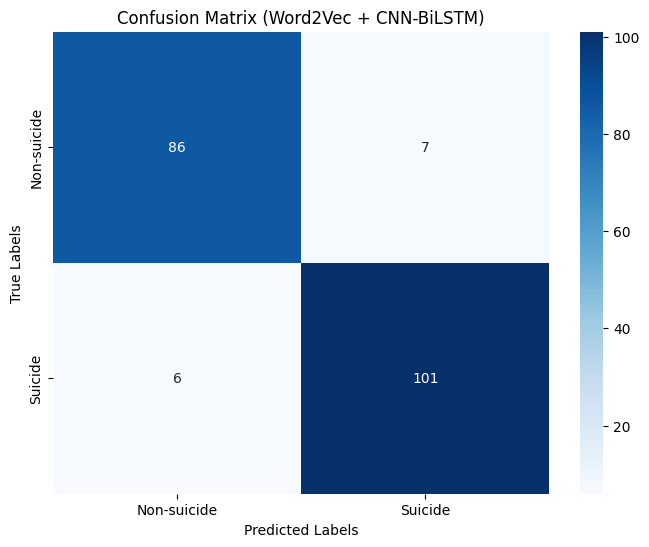

In [24]:
# Calculate confusion matrix
rf_cm = confusion_matrix(y_test_labels, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-suicide', 'Suicide'], yticklabels=['Non-suicide', 'Suicide'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Word2Vec + CNN-BiLSTM)')
plt.show()

Experiment: CNN + biLSTM + Attention

In [25]:
from keras.layers import Attention, Dot, Activation, RepeatVector, Permute, Lambda, BatchNormalization, RepeatVector
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras_self_attention import SeqSelfAttention

def create_model_with_attention(lstm_units, dense_units, dropout_rate):
    text_input = Input(shape=(max_length,), name='text_input')
    x = Embedding(num_words, 300, weights=[embedding_matrix], input_length=max_length, trainable=False)(text_input)
    x = Conv1D(100, 5, activation='relu')(x)
    x = MaxPooling1D()(x)
    x = Bidirectional(LSTM(lstm_units, dropout=dropout_rate, recurrent_dropout=dropout_rate, return_sequences=True))(x)

    attention = SeqSelfAttention(attention_activation='softmax')(x)
    flatten = Flatten()(attention)

    personality_input = Input(shape=(3,), name='personality_input')
    p = Dense(32, activation='relu')(personality_input)

    combined = Concatenate()([flatten, p])

    x = Dense(dense_units, activation='relu')(combined)
    x = Dropout(dropout_rate)(x)
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs=[text_input, personality_input], outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

    

In [26]:
#use params from reference
# lstm_units = 64
# dropout_rate = 0.5
# l2_lambda = 0.01
# learning_rate = 0.0001
# model = create_model_with_attention(lstm_units, lstm_units, dropout_rate, l2_lambda, learning_rate)
# early_stopping = EarlyStopping(monitor='loss', patience=4, restore_best_weights=True)

# Retrain the model using the best parameters
best_params = study.best_params
model2 = create_model_with_attention(best_params['lstm_units'], best_params['dense_units'], best_params['dropout_rate'])
model2.load_weights("init_weights_2.h5", by_name=True, skip_mismatch=True)  # Load the saved weights before training
model2.fit([X_train_padded, X_train[['Extraversion', 'Agreeableness', 'Neuroticism']]], y_train,
          batch_size=32,
          epochs=20)

# Evaluate the model on the test set
y_prob = model2.predict([X_test_padded, X_test[['Extraversion', 'Agreeableness', 'Neuroticism']]])
y_pred = np.argmax(y_prob, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

print('Word2Vec + CNN-BiLSTM + Attention Results:')
print(classification_report(y_test_labels, y_pred, digits=4))

Epoch 1/20


c:\Users\PC\Documents\Master_Project\Suicide-Ideation-Detection-in-Social-Media-Using-Personality-Traits-main\venv\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


25/25 [==============================] - 15s 412ms/step - loss: 0.6574 - accuracy: 0.6687
Epoch 2/20
25/25 [==============================] - 10s 405ms/step - loss: 0.4563 - accuracy: 0.8000
Epoch 3/20
25/25 [==============================] - 5s 204ms/step - loss: 0.3496 - accuracy: 0.8600
Epoch 4/20
25/25 [==============================] - 4s 171ms/step - loss: 0.3393 - accuracy: 0.8700
Epoch 5/20
25/25 [==============================] - 5s 182ms/step - loss: 0.2338 - accuracy: 0.9137
Epoch 6/20
25/25 [==============================] - 5s 185ms/step - loss: 0.1564 - accuracy: 0.9500
Epoch 7/20
25/25 [==============================] - 4s 172ms/step - loss: 0.1166 - accuracy: 0.9675
Epoch 8/20
25/25 [==============================] - 6s 231ms/step - loss: 0.0829 - accuracy: 0.9750
Epoch 9/20
25/25 [==============================] - 10s 399ms/step - loss: 0.0450 - accuracy: 0.9800
Epoch 10/20
25/25 [==============================] - 10s 401ms/step - loss: 0.0252 - accuracy: 0.9925
Epoch 

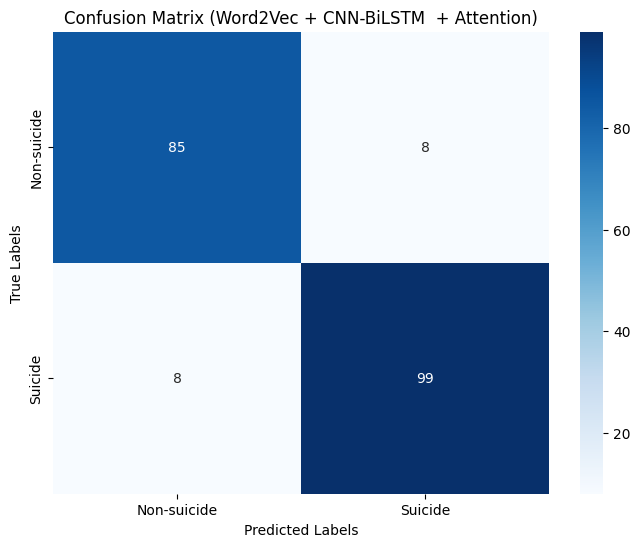

In [27]:
# Calculate confusion matrix
rf_cm = confusion_matrix(y_test_labels, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-suicide', 'Suicide'], yticklabels=['Non-suicide', 'Suicide'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Word2Vec + CNN-BiLSTM  + Attention)')
plt.show()

Experiment to avoid overfitting

In [55]:
# Text features 
from keras.models import Model, Sequential
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, Multiply, Flatten, BatchNormalization
from keras.layers import Layer
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.utils import to_categorical
from keras_self_attention import SeqSelfAttention

y_train = np.array(y_train)
y_test = np.array(y_test)

# Convert the labels to one-hot encoding
num_classes = 2
y_train_onehot = to_categorical(y_train, num_classes)
y_test_onehot = to_categorical(y_test, num_classes)

# Model Parameters (as reference)
embedding_dim = 300
filters = 100
kernel_size = 5
lstm_units = 100
dropout_rate = 0.3
l2_lambda = 0.001

# Define Model
model = Sequential()
model.add(Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False, name="embedding_layer"))
model.add(Conv1D(filters, kernel_size, activation='relu', name="conv1d_layer", kernel_regularizer=l2(l2_lambda)))
model.add(MaxPooling1D(name="max_pooling_layer"))
model.add(Bidirectional(LSTM(lstm_units, dropout=dropout_rate, recurrent_dropout=dropout_rate, return_sequences=True, name="bidirectional_lstm")))
model.add(LSTM(lstm_units, return_sequences=True, name="lstm_layer"))
model.add(SeqSelfAttention(attention_activation='softmax'))
model.add(Flatten())
model.add(Dense(64, activation='relu', name="dense_layer_1", kernel_regularizer=l2(l2_lambda)))
model.add(Dropout(dropout_rate, name="dropout_layer"))
model.add(Dense(num_classes, activation='softmax', name="output_layer"))

# Compile Model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# Train the model
batch_size = 64
epochs = 5

model.load_weights("init_weights.h5", by_name=True, skip_mismatch=True)  # Load the saved weights before training
early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
model.fit(X_train_padded, y_train_onehot,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test_padded, y_test_onehot),
          callbacks=[early_stopping])

# Evaluate the model
lstm2_y_prob = model.predict(X_test_padded)
lstm2_y_pred = np.argmax(lstm2_y_prob, axis=1)
y_test = np.argmax(y_test_onehot, axis=1)

print('Word2Vec + CNN-BiLSTM with Attention Results:')
print(classification_report(y_test, lstm2_y_pred, digits=4))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer (Embedding)  (None, 117, 300)         1419600   
                                                                 
 conv1d_layer (Conv1D)       (None, 113, 100)          150100    
                                                                 
 max_pooling_layer (MaxPooli  (None, 56, 100)          0         
 ng1D)                                                           
                                                                 
 bidirectional_16 (Bidirecti  (None, 56, 200)          160800    
 onal)                                                           
                                                                 
 lstm_layer (LSTM)           (None, 56, 100)           120400    
                                                                 
 seq_self_attention_13 (SeqS  (None, 56, 100)         

c:\Users\PC\Documents\Master_Project\Suicide-Ideation-Detection-in-Social-Media-Using-Personality-Traits-main\venv\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


13/13 [==============================] - 9s 460ms/step - loss: 0.8301 - accuracy: 0.6800 - val_loss: 0.6005 - val_accuracy: 0.8500
Epoch 2/5
13/13 [==============================] - 5s 411ms/step - loss: 0.5992 - accuracy: 0.8288 - val_loss: 0.4998 - val_accuracy: 0.8850
Epoch 3/5
13/13 [==============================] - 5s 424ms/step - loss: 0.4545 - accuracy: 0.9013 - val_loss: 0.4138 - val_accuracy: 0.9250
Epoch 4/5
13/13 [==============================] - 6s 452ms/step - loss: 0.3543 - accuracy: 0.9312 - val_loss: 0.3724 - val_accuracy: 0.9300
Epoch 5/5
7/7 [==============================] - 1s 37ms/step
Word2Vec + CNN-BiLSTM with Attention Results:
              precision    recall  f1-score   support

           0     0.9432    0.8925    0.9171        93
           1     0.9107    0.9533    0.9315       107

    accuracy                         0.9250       200
   macro avg     0.9269    0.9229    0.9243       200
weighted avg     0.9258    0.9250    0.9248       200



In [ ]:
# Text features & Personality traits 

from keras.layers import Attention, Dot, Activation, RepeatVector, Permute, Lambda
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras_self_attention import SeqSelfAttention

def create_model_with_attention2(lstm_units, dense_units, dropout_rate, l2_lambda):
    text_input = Input(shape=(max_length,), name='text_input')
    x = Embedding(num_words, 300, weights=[embedding_matrix], input_length=max_length, trainable=False)(text_input)
    x = Conv1D(100, 5, activation='relu', kernel_regularizer=l2(l2_lambda))(x)
    x = MaxPooling1D()(x)
    x = Bidirectional(LSTM(lstm_units, dropout=dropout_rate, recurrent_dropout=dropout_rate, return_sequences=True))(x)

    attention = SeqSelfAttention(attention_activation='softmax')(x)
    flatten = Flatten()(attention)

    personality_input = Input(shape=(3,), name='personality_input')
    p = Dense(32, activation='relu')(personality_input)

    combined = Concatenate()([flatten, p])

    x = Dense(dense_units, activation='relu', kernel_regularizer=l2(l2_lambda))(combined)
    x = Dropout(dropout_rate)(x)
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs=[text_input, personality_input], outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
    

In [43]:
l2_lambda = 0.002
best_params = {
    "lstm_units": 118,
    "dense_units": 52,
    "dropout_rate": 0.44257192476360746
}

# Retrain the model using the best parameters
# best_params = study.best_params
model3 = create_model_with_attention2(best_params['lstm_units'], best_params['dense_units'], best_params['dropout_rate'], l2_lambda)
model3.load_weights("init_weights_2.h5", by_name=True, skip_mismatch=True)  # Load the saved weights before training
early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
model3.fit([X_train_padded, X_train[['Extraversion', 'Agreeableness', 'Neuroticism']]], y_train,
          batch_size=32,
          epochs=20,
          callbacks=[early_stopping])

# Evaluate the model on the test set
y_prob = model3.predict([X_test_padded, X_test[['Extraversion', 'Agreeableness', 'Neuroticism']]])
y_pred = np.argmax(y_prob, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

print('Word2Vec + CNN-BiLSTM + Attention Results:')
print(classification_report(y_test_labels, y_pred, digits=4))

Epoch 1/20


c:\Users\PC\Documents\Master_Project\Suicide-Ideation-Detection-in-Social-Media-Using-Personality-Traits-main\venv\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


25/25 [==============================] - 7s 205ms/step - loss: 1.0092 - accuracy: 0.6687
Epoch 2/20
25/25 [==============================] - 5s 179ms/step - loss: 0.7492 - accuracy: 0.7837
Epoch 3/20
25/25 [==============================] - 4s 177ms/step - loss: 0.6080 - accuracy: 0.8338
Epoch 4/20
25/25 [==============================] - 4s 179ms/step - loss: 0.4653 - accuracy: 0.8850
Epoch 5/20
25/25 [==============================] - 4s 176ms/step - loss: 0.4138 - accuracy: 0.9075
Epoch 6/20
25/25 [==============================] - 4s 179ms/step - loss: 0.3796 - accuracy: 0.9050
Epoch 7/20
25/25 [==============================] - 4s 176ms/step - loss: 0.3080 - accuracy: 0.9438
Epoch 8/20
25/25 [==============================] - 4s 176ms/step - loss: 0.3109 - accuracy: 0.9362
Epoch 9/20
25/25 [==============================] - 4s 175ms/step - loss: 0.3247 - accuracy: 0.9400
Epoch 10/20
25/25 [==============================] - 5s 210ms/step - loss: 0.2558 - accuracy: 0.9688
Epoch 11/2

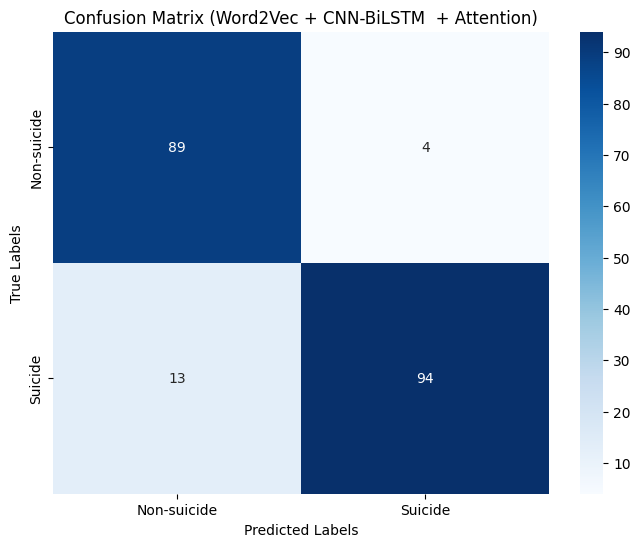

In [38]:
# Calculate confusion matrix
rf_cm = confusion_matrix(y_test_labels, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-suicide', 'Suicide'], yticklabels=['Non-suicide', 'Suicide'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Word2Vec + CNN-BiLSTM  + Attention)')
plt.show()